# Federated Unlearning

This notebook contains the code of the work described in <a href="https://arxiv.org/pdf/2207.05521.pdf">Federated Unlearning: How to Efficiently Erase a Client in FL?</a>

**Brief summary:** This work considers the case where a client (referred to as the target client) wants to opt out of federation after the federated learning process, and as a result wants to remove their contribution from the global model. We propose to perform unlearning at the client (to be erased) by reversing the learning process, i.e., training a model to maximize the local empirical loss. In particular, we formulate the unlearning problem as a constrained maximization problem by restricting to an l2-norm ball around a suitably chosen reference model to help retain some knowledge learnt from the other clients’ data. This formulation allows the client to perform the unlearning by using the Projected Gradient Descent (PGD) algorithm. To improve the performance of the unlearned model, we continue the FL process for a few rounds without the participation of the target client. Experiments
on the MNIST dataset show that the proposed unlearning method is efficient and effective.

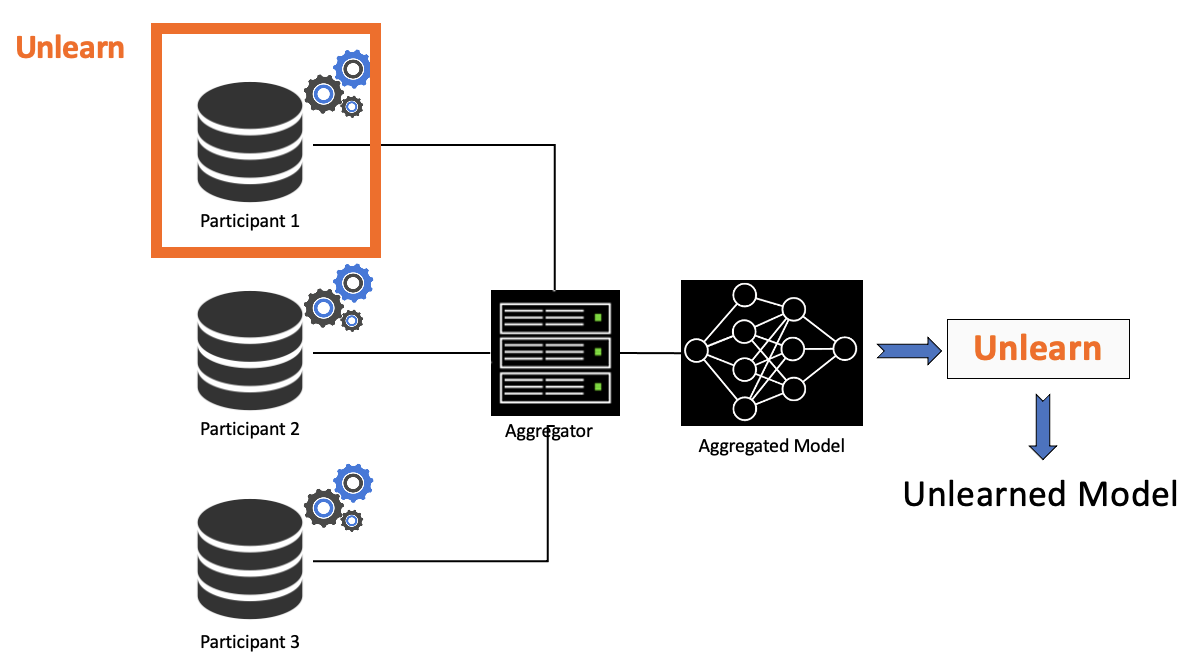

## Contents:

1. [Load prereqs and data](#section_1)
2. [Load data and backdoor a given percentage of the data of the target client](#section_2)
3. [Train the FL Model](#section_3)
4. [Unlearn the contribution of the target client](#section_4)
5. [Post-Training](#section_5)

## 1. Load prereqs 
<a id='section_1'></a>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import copy
import itertools
import math

from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

#seeds
torch.manual_seed(0)
np.random.seed(0)

#### FL Fusion Class Selection

In [2]:
def FL_round_fusion_selection(num_parties, fusion_key='FedAvg'):

    fusion_class_dict = {
        'FedAvg': FusionAvg(num_parties),
        'Retrain': FusionRetrain(num_parties), 
        'Unlearn': FusionAvg(num_parties)
        }

    return fusion_class_dict[fusion_key]

#### Set up No. of Parties, Party to be Erased, and Attack Parameters

In [3]:
num_parties = 5
scale = 1
# Currently, we assume that the party to be erased is party_id = 0
party_to_be_erased = 0
num_samples_erased_party = int(60000 / num_parties * scale)
num_samples_per_party = int((60000 - num_samples_erased_party)/(num_parties - 1))
print('Number of samples erased party:', num_samples_erased_party)
print('Number of samples other party:', num_samples_per_party)

Number of samples erased party: 12000
Number of samples other party: 12000


### 2. Load data and backdoor a given percentage of the data of the target client
<a id='section_2'></a>

**Note:** We use the backdoor triggers (Gu et al., 2017) as an effective way to evaluate the performance of unlearning methods. In particular, the target client uses a dataset with a certain fraction of images which have a backdoor trigger inserted in them. Thus, the global FL model becomes susceptible to the backdoor trigger. Then, a successful unlearning process should produce a model that reduces the accuracy on the images with the backdoor trigger, while
maintaining a good performance on regular (clean) images. Note that we use the backdoor triggers as a way to evaluate the performance of unlearning methods; we do not consider any malicious client.

Load ART

In [4]:
import numpy as np
import art
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical

Load MNIST from ART

In [5]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

x_train_party = x_train[0:num_samples_erased_party]
y_train_party = y_train[0:num_samples_erased_party]

Initialize Backdoor Pattern

In [6]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

Insert Backdoor

In [7]:
percent_poison = .8

all_indices = np.arange(len(x_train_party))
remove_indices = all_indices[np.all(y_train_party == example_target, axis=1)]

target_indices = list(set(all_indices) - set(remove_indices))
num_poison = int(percent_poison * len(target_indices))
print(f'num poison: {num_poison}')
selected_indices = np.random.choice(target_indices, num_poison, replace=False)

poisoned_data, poisoned_labels = backdoor.poison(x_train_party[selected_indices], y=example_target, broadcast=True)

poisoned_x_train = np.copy(x_train_party)
poisoned_y_train = np.argmax(y_train_party,axis=1)
for s,i in zip(selected_indices,range(len(selected_indices))):
    poisoned_x_train[s] = poisoned_data[i]
    poisoned_y_train[s] = int(np.argmax(poisoned_labels[i]))

num poison: 8636


9


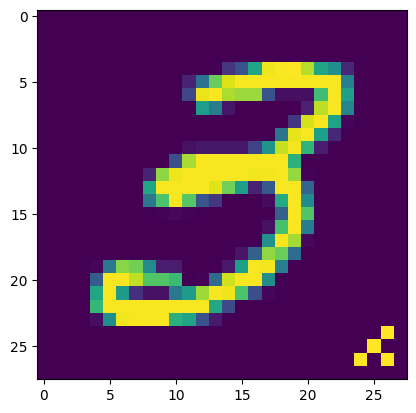

In [8]:
import matplotlib.pyplot as plt
plt.imshow(poisoned_x_train[selected_indices[0]])
print(poisoned_y_train[0])

Create PyTorch dataset from poisoned data

In [9]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

poisoned_x_train_ch = np.expand_dims(poisoned_x_train, axis = 1)
print('poisoned_x_train_ch.shape:',poisoned_x_train_ch.shape)
print('poisoned_y_train.shape:',poisoned_y_train.shape)
poisoned_dataset_train = TensorDataset(torch.Tensor(poisoned_x_train_ch),torch.Tensor(poisoned_y_train).long())
poisoned_dataloader_train = DataLoader(poisoned_dataset_train, batch_size=128, shuffle=True)

poisoned_x_train_ch.shape: (12000, 1, 28, 28)
poisoned_y_train.shape: (12000,)


Create PyTorch datasets for other parties

In [10]:
num_samples = (num_parties - 1) * num_samples_per_party
x_train_parties = x_train[num_samples_erased_party:num_samples_erased_party+num_samples] 
x_train_parties_ch = np.expand_dims(x_train_parties, axis=1)
y_train_parties = y_train[num_samples_erased_party:num_samples_erased_party+num_samples]
y_train_parties_c = np.argmax(y_train_parties, axis=1).astype(int)
print(x_train_parties_ch.shape)
print(y_train_parties_c.shape)

x_train_parties = TensorDataset(torch.Tensor(x_train_parties_ch), torch.Tensor(y_train_parties_c).long())
clean_dataset_train = torch.utils.data.random_split(x_train_parties, [num_samples_per_party for _ in range(1, num_parties)])

trainloader_lst = [poisoned_dataloader_train] 
for i in range(len(clean_dataset_train)):
    trainloader_lst.append(DataLoader(clean_dataset_train[i], batch_size=128, shuffle=True))

(48000, 1, 28, 28)
(48000,)


Create test dataloaders

In [11]:
all_indices = np.arange(len(x_test))
remove_indices = all_indices[np.all(y_test == example_target, axis=1)]

target_indices = list(set(all_indices) - set(remove_indices))
print('num poison test:', len(target_indices))
poisoned_data, poisoned_labels = backdoor.poison(x_test[target_indices], y=example_target, broadcast=True)

poisoned_x_test = np.copy(x_test)
poisoned_y_test = np.argmax(y_test,axis=1)

for s,i in zip(target_indices,range(len(target_indices))):
    poisoned_x_test[s] = poisoned_data[i]
    poisoned_y_test[s] = int(np.argmax(poisoned_labels[i]))

poisoned_x_test_ch = np.expand_dims(poisoned_x_test, axis = 1)
print(poisoned_x_test_ch.shape)
print(poisoned_y_test.shape)
poisoned_dataset_test = TensorDataset(torch.Tensor(poisoned_x_test_ch),torch.Tensor(poisoned_y_test).long())
testloader_poison = DataLoader(poisoned_dataset_test, batch_size=1000, shuffle=False)

x_test_pt = np.expand_dims(x_test, axis = 1)
y_test_pt = np.argmax(y_test,axis=1).astype(int)
print(x_test_pt.shape)
print(y_test_pt.shape)
dataset_test = TensorDataset(torch.Tensor(x_test_pt), torch.Tensor(y_test_pt).long())
testloader = DataLoader(dataset_test, batch_size=1000, shuffle=False)

num poison test: 8991
(10000, 1, 28, 28)
(10000,)
(10000, 1, 28, 28)
(10000,)


## 3. Train the FL Model
<a id='section_3'></a>

In [12]:
num_of_repeats = 1
num_fl_rounds = 10

fusion_types = ['FedAvg','Retrain']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 1 

dist_Retrain = {}
loss_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

Train and evaluate the FL Model

In [13]:
party_models_dict = {}

initial_model = FLNet()
model_dict = {}
for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

for round_num in range(num_fl_rounds): 
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=num_parties, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        current_model = copy.deepcopy(initial_model)
        current_model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        for party_id in range(num_parties):

            if fusion_key == 'Retrain' and party_id == party_to_be_erased:
                party_models.append(FLNet())
            else:
                model = copy.deepcopy(current_model)
                model_update, party_loss = local_training.train(model=model, 
                                            trainloader=trainloader_lst[party_id], 
                                            criterion=None, opt=None)

                party_models.append(copy.deepcopy(model_update))
                party_losses.append(party_loss)

        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=current_model)

        model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
        party_models_dict[fusion_key] = party_models  

        eval_model = FLNet()
        eval_model.load_state_dict(current_model_state_dict)
        clean_acc = Utils.evaluate(testloader, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')
        pois_acc = Utils.evaluate(testloader_poison, eval_model)
        pois_accuracy[fusion_key][round_num] = pois_acc
        print(f'Global Backdoor Accuracy {fusion_key}, round {round_num} = {pois_acc}')

Global Clean Accuracy FedAvg, round 0 = 73.17
Global Backdoor Accuracy FedAvg, round 0 = 37.66
Global Clean Accuracy Retrain, round 0 = 88.89
Global Backdoor Accuracy Retrain, round 0 = 11.23
Global Clean Accuracy FedAvg, round 1 = 91.64
Global Backdoor Accuracy FedAvg, round 1 = 18.9
Global Clean Accuracy Retrain, round 1 = 94.14
Global Backdoor Accuracy Retrain, round 1 = 10.36
Global Clean Accuracy FedAvg, round 2 = 94.49
Global Backdoor Accuracy FedAvg, round 2 = 21.48
Global Clean Accuracy Retrain, round 2 = 95.84
Global Backdoor Accuracy Retrain, round 2 = 10.43
Global Clean Accuracy FedAvg, round 3 = 96.17
Global Backdoor Accuracy FedAvg, round 3 = 24.93
Global Clean Accuracy Retrain, round 3 = 96.87
Global Backdoor Accuracy Retrain, round 3 = 9.88
Global Clean Accuracy FedAvg, round 4 = 96.88
Global Backdoor Accuracy FedAvg, round 4 = 41.64
Global Clean Accuracy Retrain, round 4 = 97.31
Global Backdoor Accuracy Retrain, round 4 = 10.11
Global Clean Accuracy FedAvg, round 5 = 97

In [14]:
for fusion_key in fusion_types:
    current_model_state_dict = model_dict[fusion_key]
    current_model = copy.deepcopy(initial_model)
    current_model.load_state_dict(current_model_state_dict)
    clean_acc = Utils.evaluate(testloader, current_model)
    print(f'Clean Accuracy {fusion_key}: {clean_acc}')
    pois_acc = Utils.evaluate(testloader_poison, current_model)
    print(f'Backdoor Accuracy {fusion_key}: {pois_acc}')

Clean Accuracy FedAvg: 98.29
Backdoor Accuracy FedAvg: 85.88
Clean Accuracy Retrain: 98.47
Backdoor Accuracy Retrain: 10.02


## 4. Unlearn the contribution of the target client 
<a id='section_4'></a>

In [15]:
num_updates_in_epoch = None  
num_local_epochs_unlearn = 5 
lr = 0.01
distance_threshold = 2.2
clip_grad = 5


initial_model = FLNet()
unlearned_model_dict = {}
for fusion_key in fusion_types_unlearn:
    if fusion_key == 'Retrain':
        unlearned_model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

clean_accuracy_unlearn = {}
pois_accuracy_unlearn = {}
for fusion_key in fusion_types_unlearn:
    clean_accuracy_unlearn[fusion_key] = 0
    pois_accuracy_unlearn[fusion_key] = 0

for fusion_key in fusion_types:
    if fusion_key == 'Retrain':
        continue

    initial_model = FLNet()
    fedavg_model_state_dict = copy.deepcopy(model_dict[fusion_key])
    fedavg_model = copy.deepcopy(initial_model)
    fedavg_model.load_state_dict(fedavg_model_state_dict)

    party_models = copy.deepcopy(party_models_dict[fusion_key])
    party0_model = copy.deepcopy(party_models[0])

    #compute reference model
    #w_ref = N/(N-1)w^T - 1/(N-1)w^{T-1}_i = \sum{i \ne j}w_j^{T-1}
    model_ref_vec = num_parties / (num_parties - 1) * nn.utils.parameters_to_vector(fedavg_model.parameters()) \
                               - 1 / (num_parties - 1) * nn.utils.parameters_to_vector(party0_model.parameters())

    #compute threshold
    model_ref = copy.deepcopy(initial_model)
    nn.utils.vector_to_parameters(model_ref_vec, model_ref.parameters())

    eval_model = copy.deepcopy(model_ref)
    unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
    print(f'Clean Accuracy for Reference Model = {unlearn_clean_acc}')
    unlearn_pois_acc = Utils.evaluate(testloader_poison, eval_model)
    print(f'Backdoor Accuracy for Reference Model = {unlearn_pois_acc}')

    dist_ref_random_lst = []
    for _ in range(10):
        dist_ref_random_lst.append(Utils.get_distance(model_ref, FLNet()))    

    print(f'Mean distance of Reference Model to random: {np.mean(dist_ref_random_lst)}')
    threshold = np.mean(dist_ref_random_lst) / 3
    print(f'Radius for model_ref: {threshold}')
    dist_ref_party = Utils.get_distance(model_ref, party0_model)
    print(f'Distance of Reference Model to party0_model: {dist_ref_party}')


    ###############################################################
    #### Unlearning
    ###############################################################
    model = copy.deepcopy(model_ref)

    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) 

    model.train()
    flag = False
    for epoch in range(num_local_epochs_unlearn):
        print('------------', epoch)
        if flag:
            break
        for batch_id, (x_batch, y_batch) in enumerate(trainloader_lst[party_to_be_erased]):

            opt.zero_grad()

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss_joint = -loss # negate the loss for gradient ascent
            loss_joint.backward()
            if clip_grad > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            opt.step()

            with torch.no_grad():
                distance = Utils.get_distance(model, model_ref)
                if distance > threshold:
                    dist_vec = nn.utils.parameters_to_vector(model.parameters()) - nn.utils.parameters_to_vector(model_ref.parameters())
                    dist_vec = dist_vec/torch.norm(dist_vec)*np.sqrt(threshold)
                    proj_vec = nn.utils.parameters_to_vector(model_ref.parameters()) + dist_vec
                    nn.utils.vector_to_parameters(proj_vec, model.parameters())
                    distance = Utils.get_distance(model, model_ref)

            distance_ref_party_0 = Utils.get_distance(model, party0_model)
            print('Distance from the unlearned model to party 0:', distance_ref_party_0.item())

            if distance_ref_party_0 > distance_threshold:
                flag = True
                break

            if num_updates_in_epoch is not None and batch_id >= num_updates_in_epoch:
                break
    ####################################################################                           

    unlearned_model = copy.deepcopy(model)
    unlearned_model_dict[fusion_types_unlearn[1]] = unlearned_model.state_dict() 

    eval_model = FLNet()
    eval_model.load_state_dict(unlearned_model_dict[fusion_types_unlearn[1]])
    unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
    print(f'Clean Accuracy for UN-Local Model = {unlearn_clean_acc}')
    clean_accuracy_unlearn[fusion_types_unlearn[1]] =  unlearn_clean_acc
    pois_unlearn_acc = Utils.evaluate(testloader_poison, eval_model)
    print(f'Backdoor Accuracy for UN-Local Model = {pois_unlearn_acc}')
    pois_accuracy_unlearn[fusion_types_unlearn[1]] =  pois_unlearn_acc

Clean Accuracy for Reference Model = 98.33
Backdoor Accuracy for Reference Model = 72.93
Mean distance of Reference Model to random: 456.2413635253906
Radius for model_ref: 152.08045450846353
Distance of Reference Model to party0_model: 0.45037028193473816
------------ 0
Distance from the unlearned model to party 0: 0.478500634431839
Distance from the unlearned model to party 0: 0.5444186925888062
Distance from the unlearned model to party 0: 0.6680817008018494
Distance from the unlearned model to party 0: 0.8709168434143066
Distance from the unlearned model to party 0: 1.177458643913269
Distance from the unlearned model to party 0: 1.6060115098953247
Distance from the unlearned model to party 0: 2.1738977432250977
Distance from the unlearned model to party 0: 2.901670217514038
------------ 1
Clean Accuracy for UN-Local Model = 65.8
Backdoor Accuracy for UN-Local Model = 0.0


## 5. Post-Training
<a id='section_5'></a>

In [16]:
num_fl_after_unlearn_rounds = num_fl_rounds
num_updates_in_epoch = 50
num_local_epochs = 1 

clean_accuracy_unlearn_fl_after_unlearn = {}
pois_accuracy_unlearn_fl_after_unlearn = {}
loss_unlearn = {}
for fusion_key in fusion_types_unlearn:
    clean_accuracy_unlearn_fl_after_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)
    pois_accuracy_unlearn_fl_after_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)
    loss_unlearn[fusion_key] = np.zeros(num_fl_after_unlearn_rounds)

    
for round_num in range(num_fl_after_unlearn_rounds):

    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types_unlearn:
        # Reduce num_parties by 1 to remove the erased party
        fusion = FL_round_fusion_selection(num_parties=num_parties - 1, fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(unlearned_model_dict[fusion_key])    
        current_model = FLNet()
        current_model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        for party_id in range(1, num_parties):
            model = copy.deepcopy(current_model)
            model_update, party_loss = local_training.train(model=model, 
                                        trainloader=trainloader_lst[party_id], 
                                        criterion=None, opt=None)

            party_models.append(copy.deepcopy(model_update))
            party_losses.append(party_loss)

        loss_unlearn[fusion_key][round_num] = np.mean(party_losses)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=current_model)
        unlearned_model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
        party_models_dict[fusion_key] = party_models  

        eval_model = FLNet()
        eval_model.load_state_dict(current_model_state_dict)
        unlearn_clean_acc = Utils.evaluate(testloader, eval_model)
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {unlearn_clean_acc}')
        clean_accuracy_unlearn_fl_after_unlearn[fusion_key][round_num] = unlearn_clean_acc
        unlearn_pois_acc = Utils.evaluate(testloader_poison, eval_model)
        print(f'Global Backdoor Accuracy {fusion_key}, round {round_num} = {unlearn_pois_acc}')
        pois_accuracy_unlearn_fl_after_unlearn[fusion_key][round_num] = unlearn_pois_acc


Global Clean Accuracy Retrain, round 0 = 76.61
Global Backdoor Accuracy Retrain, round 0 = 11.08
Global Clean Accuracy Unlearn, round 0 = 96.9
Global Backdoor Accuracy Unlearn, round 0 = 11.12
Global Clean Accuracy Retrain, round 1 = 90.77
Global Backdoor Accuracy Retrain, round 1 = 10.63
Global Clean Accuracy Unlearn, round 1 = 97.59
Global Backdoor Accuracy Unlearn, round 1 = 11.61
Global Clean Accuracy Retrain, round 2 = 93.06
Global Backdoor Accuracy Retrain, round 2 = 10.7
Global Clean Accuracy Unlearn, round 2 = 97.79
Global Backdoor Accuracy Unlearn, round 2 = 11.42
Global Clean Accuracy Retrain, round 3 = 94.42
Global Backdoor Accuracy Retrain, round 3 = 10.87
Global Clean Accuracy Unlearn, round 3 = 98.02
Global Backdoor Accuracy Unlearn, round 3 = 11.63
Global Clean Accuracy Retrain, round 4 = 94.9
Global Backdoor Accuracy Retrain, round 4 = 10.73
Global Clean Accuracy Unlearn, round 4 = 98.17
Global Backdoor Accuracy Unlearn, round 4 = 11.99
Global Clean Accuracy Retrain, ro

Compare the performance of the proposed unlearning method with retraining from scratch (baseline)

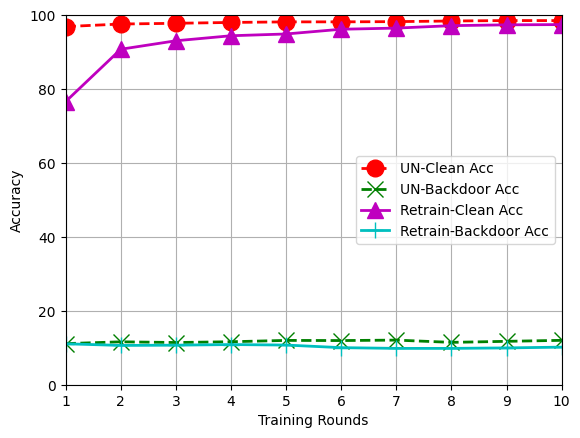

In [17]:
import matplotlib.pyplot as plt

fl_rounds = [i for i in range(1, num_fl_rounds + 1)]

plt.plot(fl_rounds, clean_accuracy_unlearn_fl_after_unlearn['Unlearn'], 'ro--', linewidth=2, markersize=12, label='UN-Clean Acc')
plt.plot(fl_rounds, pois_accuracy_unlearn_fl_after_unlearn['Unlearn'], 'gx--', linewidth=2, markersize=12, label='UN-Backdoor Acc') 
plt.plot(fl_rounds, clean_accuracy_unlearn_fl_after_unlearn['Retrain'], 'm^-', linewidth=2, markersize=12, label='Retrain-Clean Acc')
plt.plot(fl_rounds, pois_accuracy_unlearn_fl_after_unlearn['Retrain'], 'c+-', linewidth=2, markersize=12, label='Retrain-Backdoor Acc')
plt.xlabel('Training Rounds')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([0, 100])
plt.xlim([1, 10])
plt.legend()
plt.show()